In [97]:
# lstm autoencoder predict sequence
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
# Reference: https://scikit-learn.org/stable/modules/clustering.html#clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import datasets, metrics
import seaborn as sns

Define a function to convert Pandas DataFrame outputted from `satellite_imagery(..., plot_option='no')` to numpy array

In [3]:
def time_series_prep(in_df, stat_option):
    col_lst = list(in_df.columns)
    col_lst_select = [i for i in col_lst if stat_option in i]
    # Rearrange the order the columns based on YYYYMM
    col_lst_select.sort()
    out_df = in_df[col_lst_select]
    return out_df.to_numpy()

Define a function to perform K-means classification

In [66]:
def kmeans(in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    km = KMeans(n_clusters=n_classes)
    km.fit(in_arr)
    km.predict(in_arr)
    labels = km.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(in_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform Agglomerative Clustering

In [105]:
def agglomerative(in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    aggClus = AgglomerativeClustering(n_clusters=n_classes).fit(in_arr)
    labels = aggClus.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(in_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform LSTM encode and decode actions

In [7]:
def LSTM_autoencoder(in_arr, n_features, n_epochs):
    # Reference: https://machinelearningmastery.com/lstm-autoencoders/
    # reshape input into [samples, timesteps, features] if needed
    sequence = in_arr.reshape((in_arr.shape[0], in_arr.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_features, activation='relu', input_shape=(in_arr.shape[1],1)))
    model.add(RepeatVector(in_arr.shape[1]))
    model.add(LSTM(n_features, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    # fit model
    history = model.fit(sequence, sequence, validation_split = 0.5, epochs=n_epochs)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # plt.title('model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    # connect the encoder LSTM as the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[0].output)
    # get the feature vector for the input sequence
    yhat = model.predict(sequence)
    return yhat

In [89]:
def LSTM_autoencoder_plus(in_arr, n_features, n_epochs):
    check = 0
    while (check == 0):
        yhat = LSTM_autoencoder(in_arr, n_features, n_epochs)
        nrows = in_arr.shape[0]
        check = 1
        for col in range(n_features):
            n_zeros = (yhat[:,col]==0).sum()
            print('Column {} has {:.2%} of zeros'.format(col, n_zeros/nrows))
            if n_zeros == nrows:
                check = 0
        if check == 0:
            print('At least 1 column is all zeros. Refit -------------------------------------------')
    return yhat

Read in data output from `GEE_SatelliteImagery_EDA.ipynb`

In [2]:
ID_df = pd.read_csv('time_series_ID_scale10.csv')
ID_df.head()

,Unnamed: 0,lat,lon,201805_NDVI,201805_SAVI,201805_EVI,201812_NDVI,201812_SAVI,201812_EVI,201801_NDVI,...,201810_EVI,201808_NDVI,201808_SAVI,201808_EVI,201809_NDVI,201809_SAVI,201809_EVI,201807_NDVI,201807_SAVI,201807_EVI
0,0,43.768661,-116.739350,0.176445,0.264642,0.561106,0.110320,0.165463,1.181932,-0.014664,...,2.157721,0.664816,0.997105,-7.735765,0.714488,1.071605,12.477374,0.653170,0.979619,-3.501948
1,1,43.768661,-116.739260,0.172219,0.258304,0.530505,0.100356,0.150518,1.080581,-0.018005,...,2.201001,0.665370,0.997933,-18.304278,0.692162,1.038121,11.431691,0.662800,0.994062,-2.991320
2,2,43.768661,-116.739170,0.166754,0.250107,0.514179,0.088017,0.132011,1.120817,-0.022291,...,2.114196,0.660143,0.990098,-19.423686,0.702319,1.053354,10.833210,0.647084,0.970498,-2.342274
3,3,43.768661,-116.739081,0.165201,0.247778,0.498756,0.108057,0.162068,1.569025,-0.022249,...,1.722504,0.658597,0.987778,-6.962047,0.704748,1.056998,12.353717,0.615602,0.923282,-4.086213
4,4,43.768661,-116.738991,0.165201,0.247778,0.498756,0.108057,0.162068,1.569025,-0.022249,...,1.722504,0.658597,0.987778,-6.962047,0.704748,1.056998,12.353717,0.615602,0.923282,-4.086213


In [4]:
ID_arr = time_series_prep(in_df=ID_df, stat_option='NDVI')

Model 1: K-Means

Silhouette Coefficient is:  0.8010584381221377


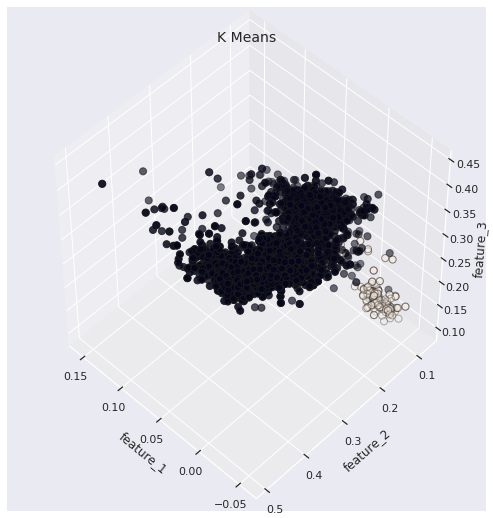

In [71]:
ID_label = kmeans(in_arr=ID_arr, n_classes=2)

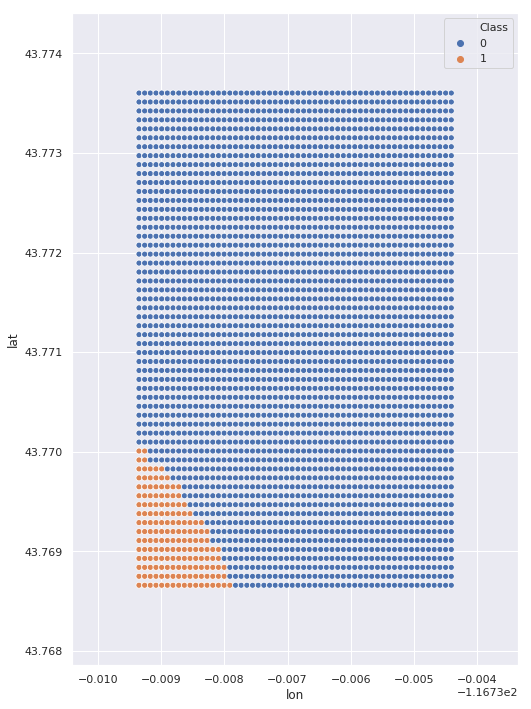

In [72]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 2: Agglomerative Clustering

Silhouette Coefficient is:  0.796961363954133


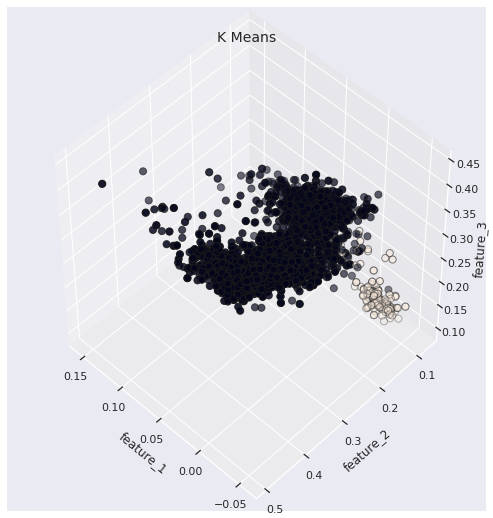

In [111]:
ID_label = agglomerative(in_arr=ID_arr, n_classes=2)

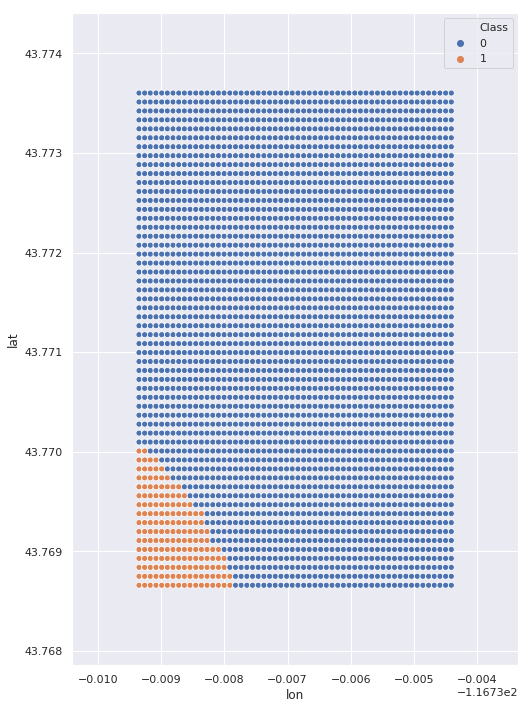

In [112]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 3: LSTM Autoencoder + K-Means

Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 692us/step - loss: 0.1767 - val_loss: 0.1105
Epoch 2/50
1568/1568 [==============================] - 1s 359us/step - loss: 0.0994 - val_loss: 0.0784
Epoch 3/50
1568/1568 [==============================] - 0s 298us/step - loss: 0.0876 - val_loss: 0.0756
Epoch 4/50
1568/1568 [==============================] - 1s 354us/step - loss: 0.0871 - val_loss: 0.0751
Epoch 5/50
1568/1568 [==============================] - 0s 285us/step - loss: 0.0866 - val_loss: 0.0751
Epoch 6/50
1568/1568 [==============================] - 1s 349us/step - loss: 0.0862 - val_loss: 0.0746
Epoch 7/50
1568/1568 [==============================] - 0s 286us/step - loss: 0.0858 - val_loss: 0.0740
Epoch 8/50
1568/1568 [==============================] - 1s 349us/step - loss: 0.0854 - val_loss: 0.0740
Epoch 9/50
1568/1568 [==============================] - 0s 287us/step - loss: 0.0849 - val_loss: 0.0739
Epoch 10/50
1568

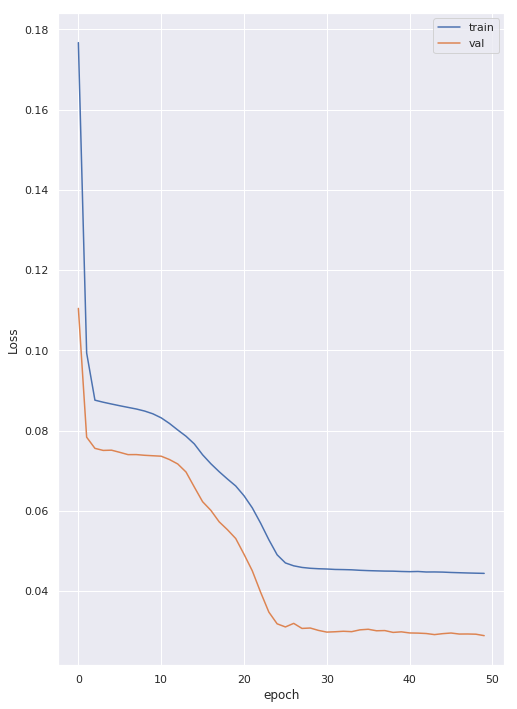

Column 0 has 0.00% of zeros
Column 1 has 0.10% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 710us/step - loss: 0.1307 - val_loss: 0.0860
Epoch 2/50
1568/1568 [==============================] - 1s 363us/step - loss: 0.0912 - val_loss: 0.0794
Epoch 3/50
1568/1568 [==============================] - 0s 300us/step - loss: 0.0893 - val_loss: 0.0777
Epoch 4/50
1568/1568 [==============================] - 1s 356us/step - loss: 0.0881 - val_loss: 0.0769
Epoch 5/50
1568/1568 [==============================] - 0s 303us/step - loss: 0.0870 - val_loss: 0.0752
Epoch 6/50
1568/1568 [==============================] - 1s 401us/step - loss: 0.0861 - val_loss: 0.0742
Epoch 7/50
1568/1568 [==============================] - 0s 297us/step - loss: 0.0851 - val_loss: 0.0730
Epoch 8/50
1568/1568 [==============================] - 

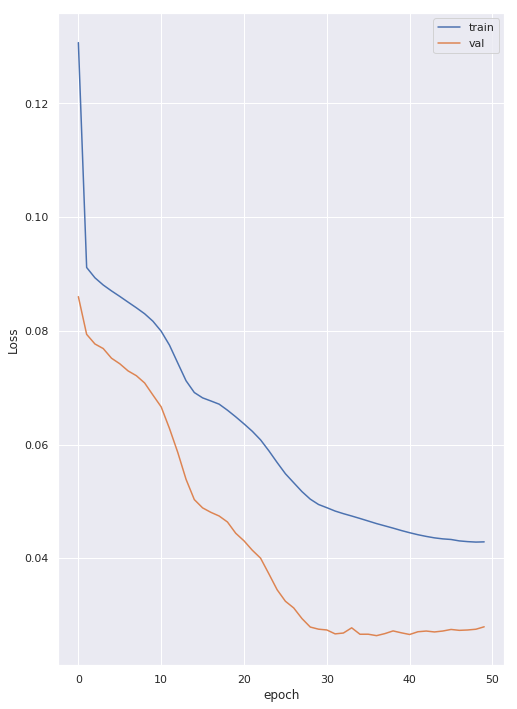

Column 0 has 99.81% of zeros
Column 1 has 10.68% of zeros
Column 2 has 0.00% of zeros


In [90]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

Silhouette Coefficient is:  0.8226943


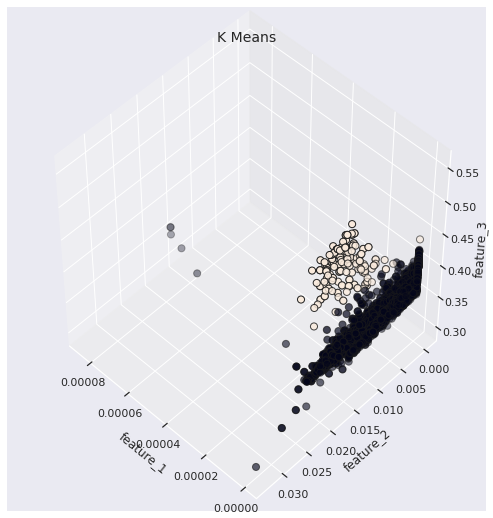

In [95]:
ID_label = kmeans(in_arr=ID_feature, n_classes=2)

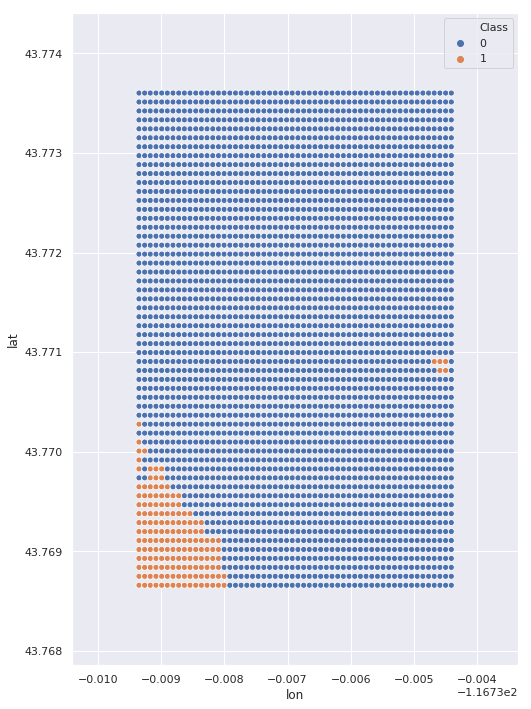

In [96]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')